# Spectrum CTIO
=========================

- Author : Sylvie Dagoret-Campagne
-  Date : November 6th 2016
- Update : November 7th 2016
- Analysis of the first image of CTIO August 2016

#### Slide show in notebook


- For the slide show, it is necessary to install RISE from damian avila:
https://github.com/damianavila/RISE

- this add an icon aside the CellToolbar

In [465]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from astropy.modeling import models
from astropy import units as u
from astropy import nddata
from astropy.io import fits

import ccdproc
print 'ccdproc version',ccdproc.__version__

from astropy.modeling import models

ccdproc version 1.0.1


In [466]:
from scipy import stats  
from scipy import ndimage
import os
from datetime import datetime, timedelta

In [467]:
import bottleneck as bn  # numpy's masked median is slow...really slow (in version 1.8.1 and lower)
print 'bottleneck version',bn.__version__

bottleneck version 1.0.0


In [468]:
import photutils
from astropy.stats import sigma_clipped_stats
from photutils import daofind
from photutils import CircularAperture
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
#from photutils.background import Background2D
from photutils import Background2D, SigmaClip, MedianBackground

In [469]:
from mpl_toolkits.mplot3d import Axes3D
import scipy.signal
from scipy import ndimage

In [470]:
from IPython.display import Image, display

In [471]:
import matplotlib
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

In [472]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (6, 6),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

## Defines file parameters
=================================

In [473]:
path_img='/Users/dagoret-campagnesylvie/MacOsX/LSST/MyWork/GitHub/CTIOData2016'
file_img='fileno016.fits'
object_name='fileno016'

In [474]:
fullfile=os.path.join(path_img,file_img)

## Open file
===============

In [475]:
hdu_list=fits.open(fullfile)
hdu_list.info()

Filename: /Users/dagoret-campagnesylvie/MacOsX/LSST/MyWork/GitHub/CTIOData2016/fileno016.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU     135   (2168, 2048)   int16 (rescales to uint16)   


In [476]:
image_data = hdu_list[0].data

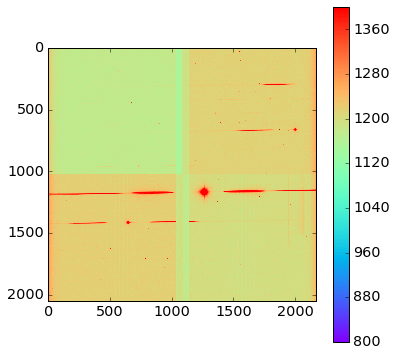

In [477]:
im=plt.imshow(image_data,cmap='rainbow',vmin=800,vmax=1400)
plt.colorbar(im)

## Find Overscan region
==============================
- The overscan region shows no sky photon background

In [478]:
profile_x=np.average(image_data,axis=0)
profile_y=np.average(image_data,axis=1)

In [479]:
prof_max=1300
prof_min=1100
prof_cut=1190 # vertical cut
x_cut1=1034   # horizontal cut
x_cut2=1133   # horizontal cut

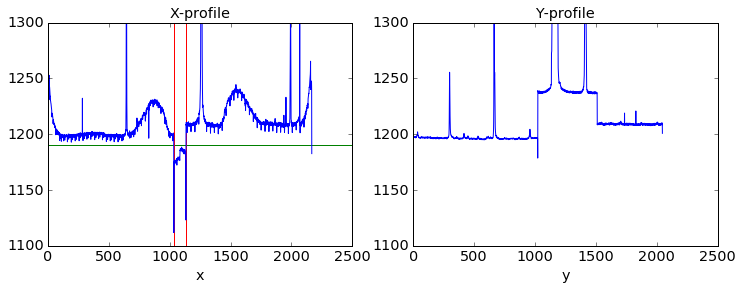

In [480]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(12.,4))
ax1.plot([0,2500],[prof_cut,prof_cut],'g-') # horizontal line for the cut value
ax1.plot([x_cut1,x_cut1],[prof_min,prof_max],'r-')   # vertical line1
ax1.plot([x_cut2,x_cut2],[prof_min,prof_max],'r-')   # vertical line1
ax1.plot(profile_x) ; ax1.set_ylim(prof_min,prof_max) ;ax1.set_title('X-profile') ; ax1.set_xlabel('x')
ax2.plot(profile_y); ax2.set_ylim(prof_min,prof_max) ;ax2.set_title('Y-profile') ; ax2.set_xlabel('y')

In [481]:
# plot the xaxis below the green line
np.where(profile_x<prof_cut)

(array([   0, 1034, 1035, 1036, 1037, 1038, 1039, 1040, 1041, 1042, 1043,
        1044, 1045, 1046, 1047, 1048, 1049, 1050, 1051, 1052, 1053, 1054,
        1055, 1056, 1057, 1058, 1059, 1060, 1061, 1062, 1063, 1064, 1065,
        1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076,
        1077, 1078, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087,
        1088, 1089, 1090, 1091, 1092, 1093, 1094, 1095, 1096, 1097, 1098,
        1099, 1100, 1101, 1102, 1103, 1104, 1105, 1106, 1107, 1108, 1109,
        1110, 1111, 1112, 1113, 1114, 1115, 1116, 1117, 1118, 1119, 1120,
        1121, 1122, 1123, 1124, 1125, 1126, 1127, 1128, 1129, 1130, 1131,
        1132, 1133, 2167]),)

## Remove overscan region
===================================

- Defines a left part and a right part of the image

In [482]:
#remove overscan region. 
image_left=image_data[:,0:x_cut1]
#image_left=image_data[:,0:x_cut1+1]
image_right=image_data[:,x_cut2+1:]
#image_right=image_data[:,x_cut2:]

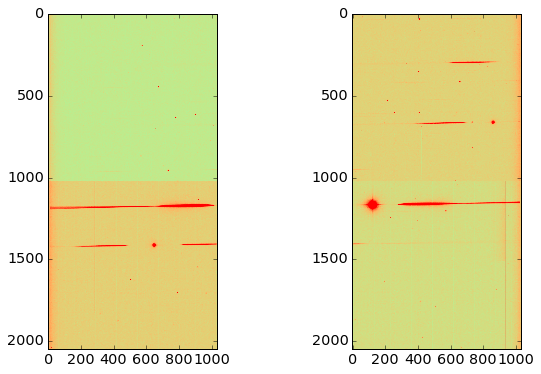

In [483]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(10.,6))
im1=ax1.imshow(image_left,cmap='rainbow',vmin=800,vmax=1400)
im2=ax2.imshow(image_right,cmap='rainbow',vmin=800,vmax=1400)

## Glue of the two parts of the image
==============================================

In [484]:
image_glued=np.concatenate((image_left,image_right),axis=1)

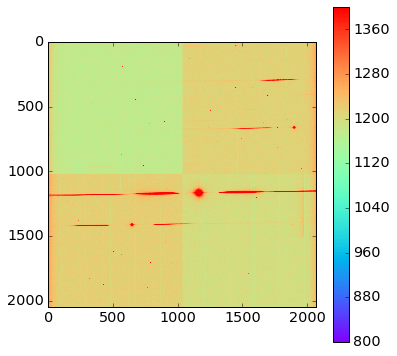

In [485]:
im=plt.imshow(image_glued,cmap='rainbow',vmin=800,vmax=1400)
plt.colorbar(im)

## Check the profile of the glued image
=================================================

- The purpose is to see the different level of pedestal

In [486]:
profile_x=np.average(image_glued,axis=0)
profile_y=np.average(image_glued,axis=1)

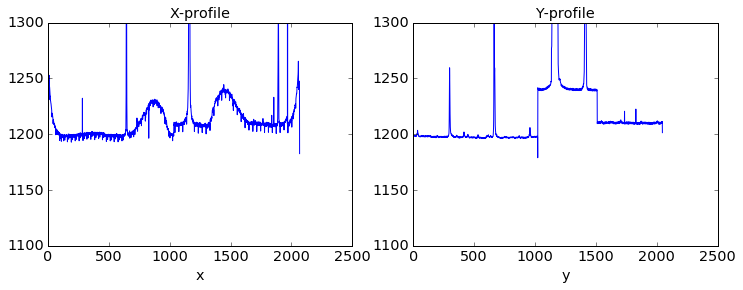

In [487]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(12.,4))
ax1.plot(profile_x) ; ax1.set_ylim(prof_min,prof_max), ax1.set_title('X-profile'); ax1.set_xlabel('x')
ax2.plot(profile_y); ax2.set_ylim(prof_min,prof_max); ax2.set_title('Y-profile'); ax2.set_xlabel('y')

## histograms of glued image value
=============================================

In [488]:
print(type(image_glued))
print('image shape',image_glued.shape)
themin=image_glued.min()
themax=image_glued.max()
print('min and max',themin,themax)

<type 'numpy.ndarray'>
('image shape', (2048, 2068))
('min and max', 771, 62969)


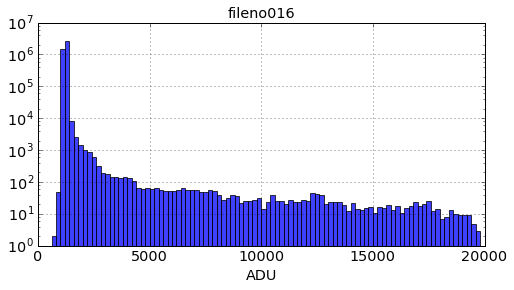

In [489]:
title=object_name;
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111)
image_flat=image_glued.flatten()
plt.hist(image_flat,bins=100,range=(0,20000),facecolor='blue', alpha=0.75);
ax.set_title(title) ; ax.set_xlabel('ADU'); ax.grid(True)
plt.yscale('log')
plt.show()

### Transfer the image in CCDData
====================================

In [490]:
ccd=ccdproc.CCDData(image_glued,unit='adu')

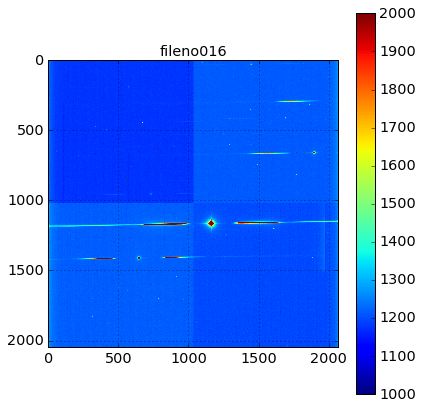

In [491]:
fig, ax = plt.subplots(figsize=(6,6))
img=ax.imshow(ccd,vmin=1000,vmax=2000.)
plt.title(object_name)
plt.tight_layout() ; plt.colorbar(img) ; plt.grid(True) ; plt.savefig(object_name)

## Extraction of Background
===============================

In [492]:
sigma_clip = SigmaClip(sigma=3., iters=10)

In [493]:
bkg_estimator = MedianBackground()

In [494]:
bkg = Background2D(ccd, (70, 70), filter_size=(3, 3),method='median')
#bkg = Background2D(ccd.data, (50, 50), filter_size=(3, 3),sigma_clip=sigma_clip,bkg_estimator=bkg_estimator)

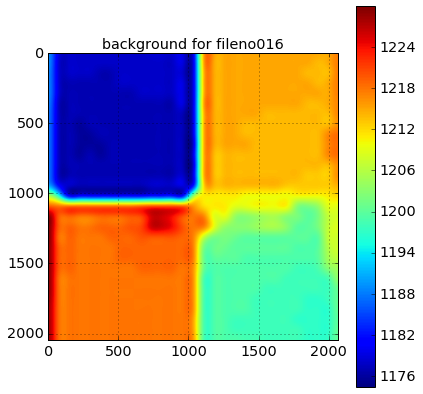

In [495]:
fig, ax = plt.subplots(figsize=(6,6))
img=ax.imshow(bkg.background)
title = 'background for '+ object_name
plt.title(title) ; plt.tight_layout() ; plt.colorbar(img) ; plt.grid(True)

## Structure of the background
==================================

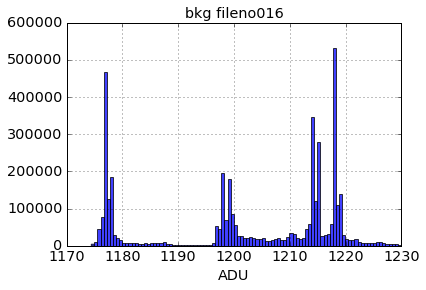

In [496]:
title='bkg '+object_name
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)
bkg_data=bkg.background
bkg_flat=bkg_data.flatten()
plt.hist(bkg_flat,bins=100,facecolor='blue', alpha=0.75);
ax.set_title(title) ; ax.set_xlabel('ADU') ;ax.grid(True)
plt.show()

In [497]:
print('median background = ',bkg.background_median)
print('median rms = ',bkg.background_rms_median)

('median background = ', 1210.0)
('median rms = ', 6.109208167652123)


## Image with  background subtraction
========================================

In [498]:
PedestalShift=60

In [499]:
ccd_bgsub=ccd - bkg.background+PedestalShift

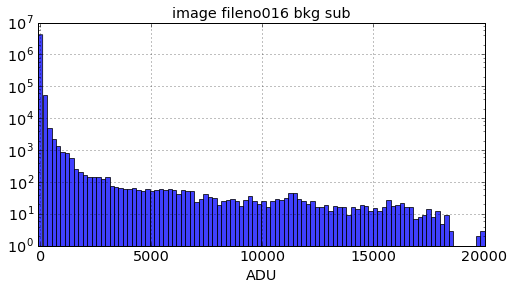

In [500]:
title='image '+object_name+' bkg sub'
fig = plt.figure(figsize=(8,4)) ; ax = fig.add_subplot(111)
ccd_bgsub_flat=ccd_bgsub.flatten()
plt.hist(ccd_bgsub_flat,bins=100,range=(-100,20000.),facecolor='blue', alpha=0.75);
ax.set_title(title) ; ax.set_xlabel('ADU') ; ax.grid(True) ; plt.yscale('log'); plt.xlim(-100,20000) ; plt.show()

## Zoom on the background

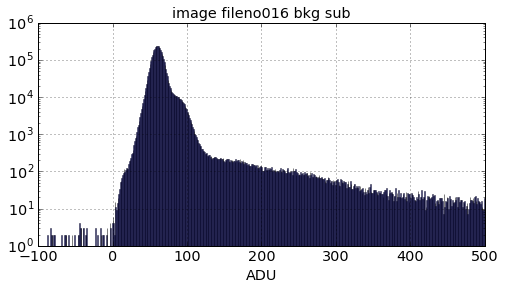

In [501]:
title='image '+object_name+' bkg sub'
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111)
ccd_bgsub_flat=ccd_bgsub.flatten()
plt.hist(ccd_bgsub_flat,bins=600,range=(-100,500.),facecolor='blue', alpha=0.5);
ax.set_title(title) ; ax.set_xlabel('ADU') ; ax.grid(True)
plt.yscale('log')
plt.show()

## image corrected from background
==============================================

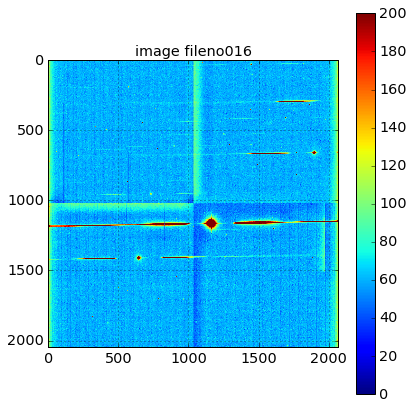

In [502]:
title='image '+object_name
fig, ax = plt.subplots(figsize=(6, 6))
img=ax.imshow(ccd_bgsub,vmin=0,vmax=200.)
plt.title(title) ; plt.tight_layout() ; plt.colorbar(img) ; plt.grid(True)

## Rotation of the image
==========================

In [503]:
rotated_image=ndimage.interpolation.rotate(ccd_bgsub,-1)

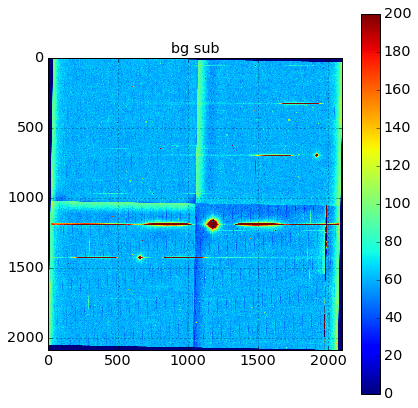

In [504]:
fig, ax = plt.subplots(figsize=(6,6))
img=ax.imshow(rotated_image,vmin=0,vmax=200.)
plt.title('bg sub') ; plt.tight_layout() ; plt.colorbar(img) ; plt.grid(True)

## The maximum position
=================================

In [505]:
themaximum=rotated_image.max()

In [506]:
imax,jmax = np.unravel_index(rotated_image.argmax(),rotated_image.shape)
print imax,' ',jmax

1208   1175


In [507]:
max_index_y=rotated_image.shape[0]-1
max_index_x=rotated_image.shape[1]-1

## Extraction of spectra region
=================================

In [508]:
imax=1190    # I have chosen by hand the imax
w=10         # width of the spectrum

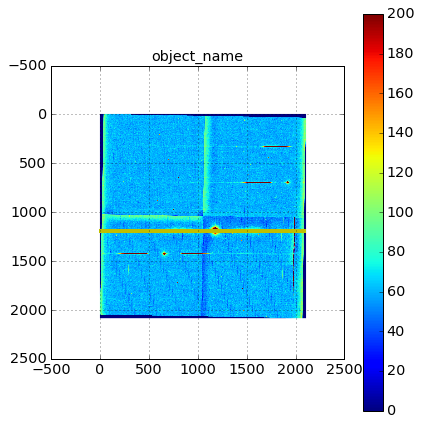

In [509]:
fig, ax = plt.subplots(figsize=(6,6))
img=ax.imshow(rotated_image,vmin=0,vmax=200.)
plt.colorbar(img)
ax.plot([0, max_index_x], [imax-w, imax-w], color='y', linestyle='-', linewidth=2)
ax.plot([0,max_index_x], [imax+w, imax+w], color='y', linestyle='-', linewidth=2)
plt.title('object_name') ; plt.tight_layout() ; plt.grid(True)

## Profiles of three vertical slices
=========================================

In [510]:
profile1=np.sum(rotated_image[:,700:1000],axis=1)  # left wing profile
profile2=np.sum(rotated_image[:,1200:1300],axis=1) # central star profile
profile3=np.sum(rotated_image[:,1300:1800],axis=1) # right wing profile 

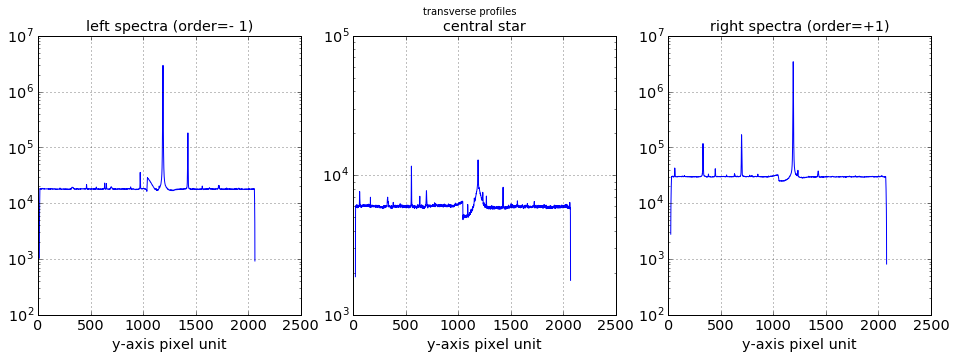

In [511]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(16.,5))
ax1.semilogy(profile1) ; ax1.grid(True) ; ax1.set_title('left spectra (order=- 1)'); ax1.set_xlabel('y-axis pixel unit')
ax2.semilogy(profile2) ; ax2.grid(True) ; ax2.set_title('central star'); ax2.set_xlabel('y-axis pixel unit')
ax3.semilogy(profile3) ; ax3.grid(True) ; ax3.set_title('right spectra (order=+1)'); ax3.set_xlabel('y-axis pixel unit')
plt.suptitle('transverse profiles')

## Zoom on vertical profiles
===================================

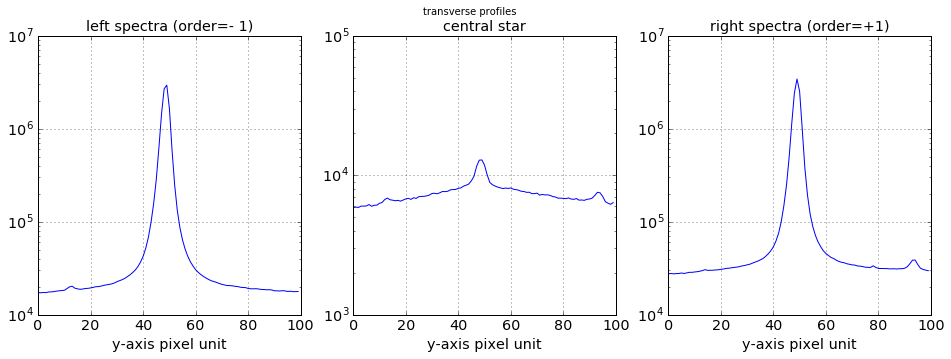

In [512]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(16.,5))
ax1.semilogy(profile1[imax-5*w:imax+5*w]); ax1.grid(True) ; ax1.set_title('left spectra (order=- 1)') ; ax1.set_xlabel('y-axis pixel unit')
ax2.semilogy(profile2[imax-5*w:imax+5*w]); ax2.grid(True) ; ax2.set_title('central star') ; ax2.set_xlabel('y-axis pixel unit')
ax3.semilogy(profile3[imax-5*w:imax+5*w]); ax3.grid(True) ; ax3.set_title('right spectra (order=+1)') ; ax3.set_xlabel('y-axis pixel unit')
plt.suptitle('transverse profiles')

## Extraction of spectrum region
=========================================

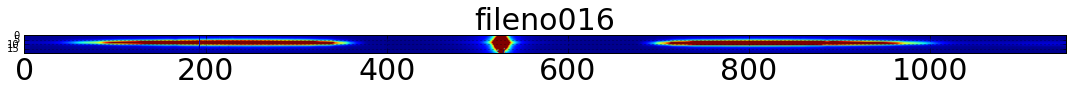

In [513]:
fig, ax = plt.subplots(figsize=(15, 10))
spectraregion=np.copy(rotated_image[imax-w:imax+w,650:1800])
spectraregionav=spectraregion/(2*w)
ax.imshow(spectraregionav,vmin=0,vmax=200.)
ax.tick_params(axis='x', labelsize=30)
ax.tick_params(axis='y', labelsize=10)
ax.grid(True)
plt.title(object_name,fontsize=30)
plt.tight_layout()

## 3D view of the spectrum
===================================

In [514]:
img=np.copy(spectraregionav)
img=img[:,525:1025]
data_array = ndimage.filters.gaussian_filter(img, 2, mode='nearest')
x_data, y_data = np.meshgrid( np.arange(data_array.shape[1]), np.arange(data_array.shape[0]) )
x_data = x_data.flatten()
y_data = y_data.flatten()
z_data = data_array.flatten()

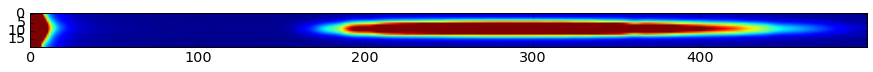

In [515]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.imshow(data_array,vmin=0,vmax=200.)

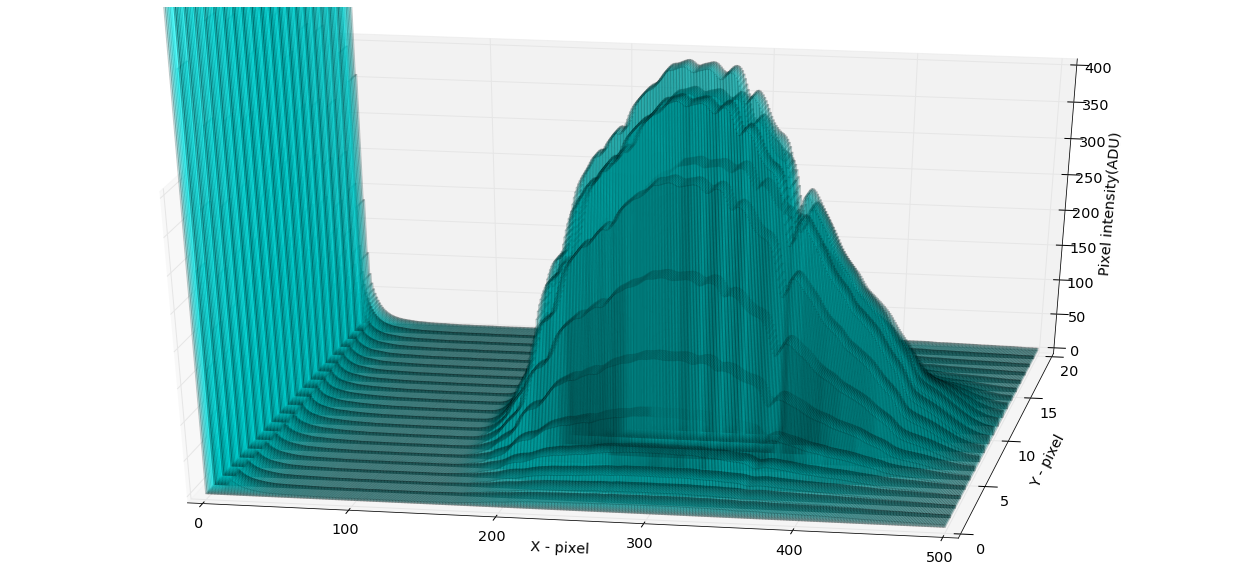

In [516]:
fig = plt.figure(figsize=(22,10))
ax = fig.add_subplot(111, projection='3d')
ax.bar3d( x_data,y_data,np.zeros(len(z_data)),1, 1, z_data,color='aqua', zsort='average' ,alpha=0.1)
ax.set_xlabel('X - pixel ') ; ax.set_ylabel('Y - pixel ') ; ax.set_zlabel('Pixel intensity(ADU)')
ax.view_init(elev=30, azim=-80); ax.dist=9.  
ax.set_xlim3d(0, 500); ax.set_ylim3d(0, 20); ax.set_zlim3d(0, 400);
plt.show()

## 2D Histogram

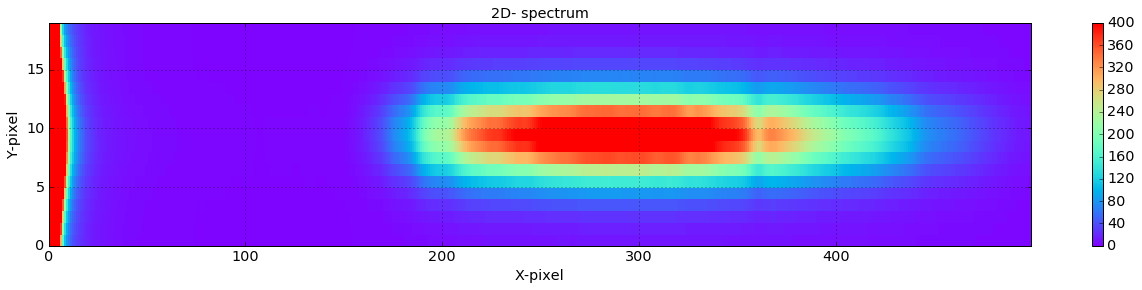

In [517]:
fig = plt.figure(figsize=(22,4))
X,Y=np.meshgrid(np.arange(0,data_array.shape[1]),np.arange(data_array.shape[0]))
im = plt.pcolormesh(X,Y,data_array, cmap='rainbow',vmin=0,vmax=400)
plt.colorbar(im, orientation='vertical')
plt.axis([X.min(), X.max(), Y.min(), Y.max()]); plt.grid(True)
plt.xlabel('X-pixel'); plt.ylabel('Y-pixel'); title='2D- spectrum' ; plt.title(title) ; plt.show()

### Spectrum 1D
==============

In [518]:
spectrum=np.sum(spectraregionav,axis=0)

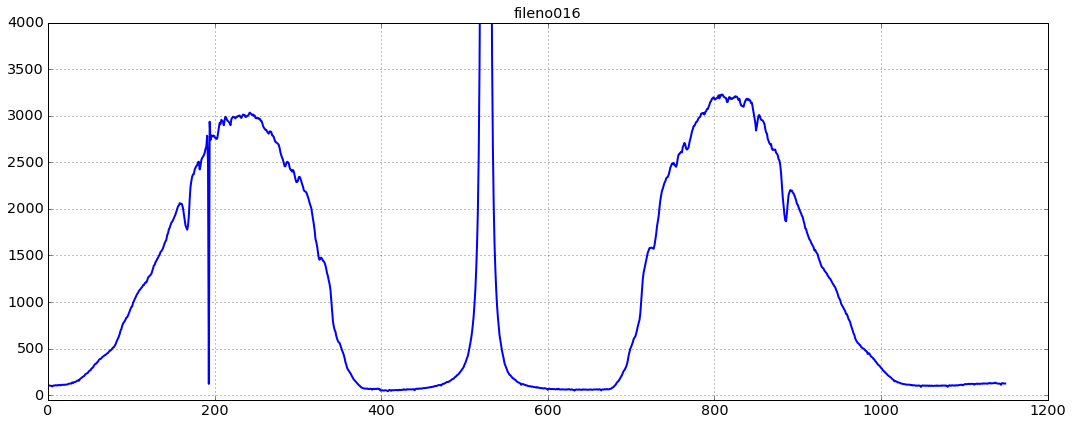

In [519]:
fig, ax = plt.subplots(figsize=(15, 6))
plt.plot(spectrum,lw=2)
plt.ylim(-50.,4000.) ; plt.title(object_name) ; plt.tight_layout() ;plt.grid(True)

## Remove the central star
==================================

In [520]:
spectrum2=np.copy(spectrum)
spectrum2[400:600]=0

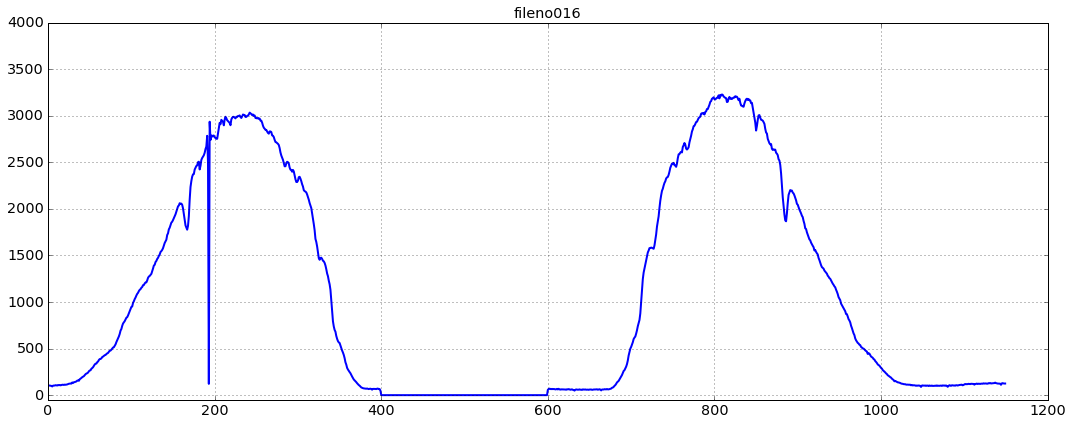

In [521]:
fig, ax = plt.subplots(figsize=(15, 6))
plt.plot(spectrum2,lw=2)
plt.ylim(-50.,4000.)
plt.title(object_name) ; plt.tight_layout() ; plt.grid(True)

## Split the spectrum in 2 parts
=======================================

In [522]:
def GetSpectrumBackground(inspectra,start,stop,skybg):
    '''
    Return the background    
    '''
    cropedbg=inspectra[start:stop]
    purebg=cropedbg[np.where(cropedbg!=skybg)]  # remove region of the bing star
    
    return purebg

In [523]:
def SeparateSpectra(inspectra,x0):
    '''
    Cut the two spectra
    '''
    rightspectra=inspectra[x0:]
    revleftspectra=inspectra[:x0]
    leftspectra=   revleftspectra[::-1]
    #rightspectra=rightspectra[np.where(rightspectra>0)]
    #leftspectra=leftspectra[np.where(leftspectra>0)]
    
    return leftspectra,rightspectra

In [524]:
def DiffSpectra(spec1,spec2,bg):
    '''
    Make the difference of the tow spectra 
    
    '''
    N1=spec1.shape[0]
    N2=spec2.shape[0]
    N=np.min([N1,N2])
    spec1_croped=spec1[0:N]
    spec2_croped=spec2[0:N]
    diff_spec=np.average((spec1_croped-spec2_croped)**2)/bg**2
    return diff_spec  

In [525]:
spec1,spec2=SeparateSpectra(spectrum2,527)

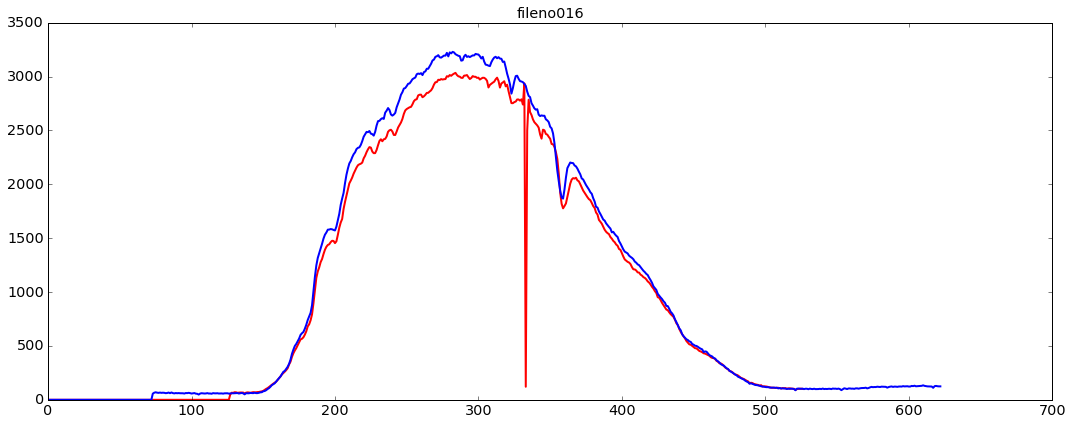

In [526]:
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(spec1,'r-',lw=2)
ax.plot(spec2,'b-',lw=2)
plt.title(object_name)
plt.tight_layout()

In [527]:
def FindCenter(fullspectrum,xmin,xmax,specbg):
    '''
    '''   
    all_x0=np.arange(xmin,xmax,1)
    NBPOINTS=np.shape(all_x0)
    chi2=np.zeros(NBPOINTS)
    for idx,x0 in np.ndenumerate(all_x0):
        spec1,spec2=SeparateSpectra(fullspectrum,x0)
        chi2[idx]=DiffSpectra(spec1,spec2,specbg)
    return all_x0,chi2

In [528]:
origins,thechi2=FindCenter(spectrum2,400,700,1)

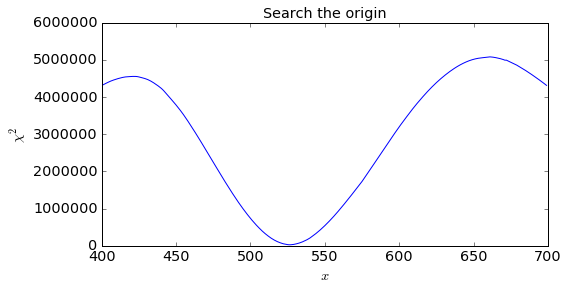

In [529]:
fig = plt.figure(figsize=(8,4))
plt.plot(origins,thechi2)
plt.title('Search the origin')
plt.ylabel('$\chi^2$')
plt.xlabel('$x$')
#plt.ylim(0,200.)

In [530]:
# find where is the minimum of chi2
indexmin=np.where(thechi2==thechi2.min())[0]
theorigin=origins[indexmin]
print indexmin[0],theorigin[0],thechi2.min()

127 527 27609.0721343


In [531]:
spec1,spec2=SeparateSpectra(spectrum2,theorigin[0])

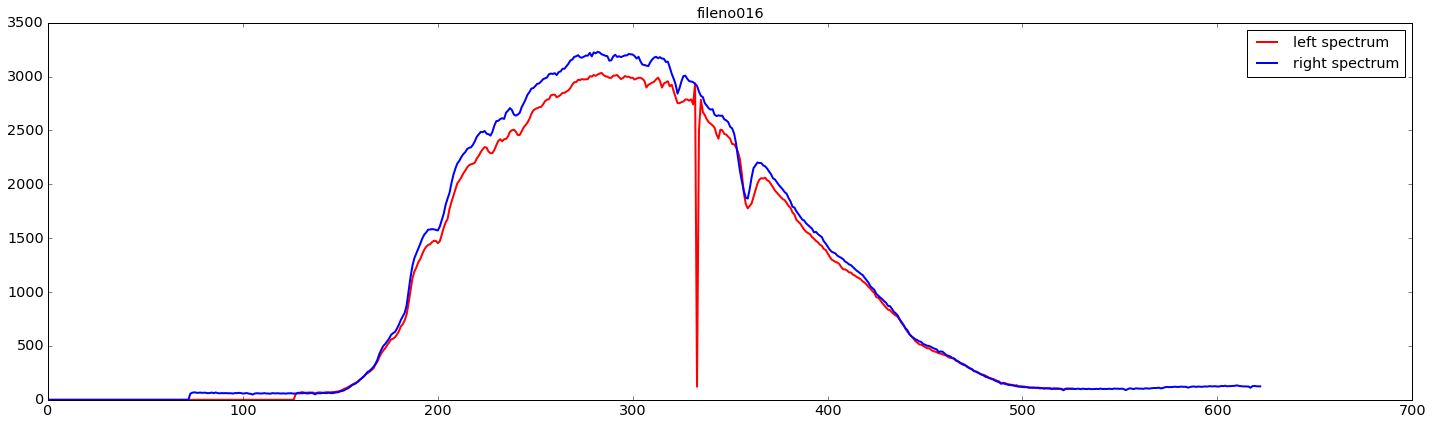

In [532]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(spec1,color='r',lw=2,label='left spectrum')
ax.plot(spec2,color='b',lw=2,label='right spectrum')
plt.title(object_name) ; plt.legend(loc='best') ;plt.tight_layout()

In [533]:
bbbg1=spec1[80:150]
bbbg2=spec2[80:150]
bbbg=0.5*(bbbg1.std()+bbbg2.std())
print bbbg

17.6941540846


## Gain calibration
========================

In [534]:
gains=np.linspace(0.5,1.5,1000)
NBGAINS=gains.shape[0]
chi2New=np.zeros(NBGAINS)

In [535]:
def DiffAmplitudes(sp1,sp2,gain,basebg):
    '''
    get the differences of the spectra for that gain
    '''    
    return DiffSpectra(sp1,gain*sp2,basebg)

In [536]:
for idx,gain in np.ndenumerate(gains):
    chi2New[idx]=DiffAmplitudes(spec1,spec2,gain,bbbg)

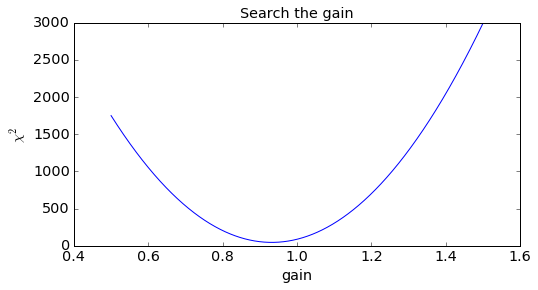

In [537]:
fig = plt.figure(figsize=(8,4))
plt.plot(gains,chi2New)
plt.title('Search the gain')
plt.xlabel('gain')
plt.ylabel('$\chi^2$')

In [538]:
thegain=gains[np.where(chi2New==chi2New.min())]
print thegain

[ 0.93143143]


In [539]:
spec2=spec2*thegain

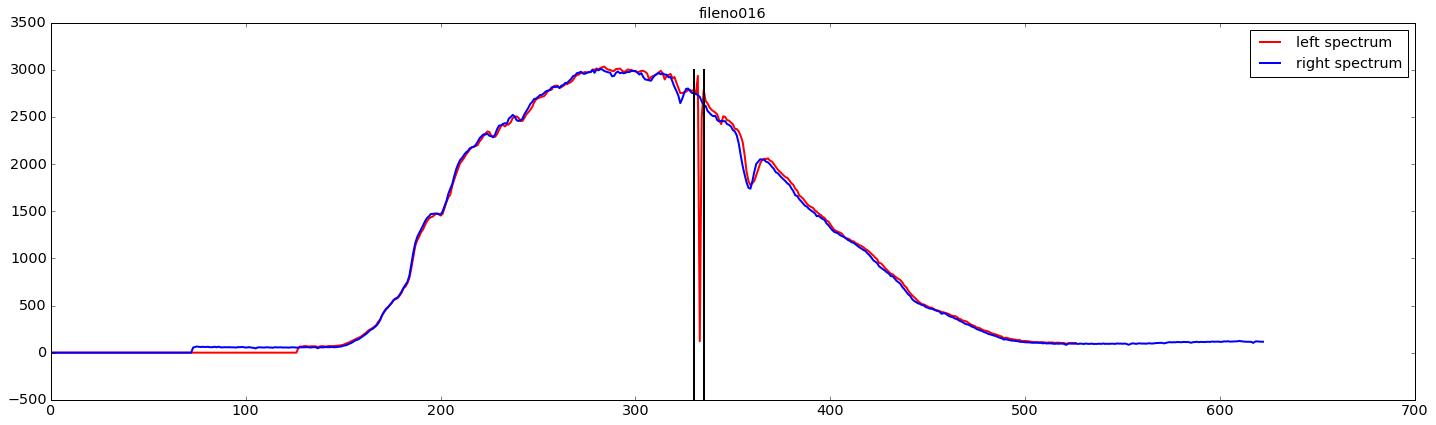

In [540]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(spec1,color='r',lw=2,label='left spectrum')
ax.plot(spec2,color='b',lw=2,label='right spectrum')
plt.title(object_name) ; plt.legend(loc='best') ; plt.tight_layout()
plt.plot([330,330],[-500,3000],'k-',lw=2)
plt.plot([335,335],[-500,3000],'k-',lw=2)

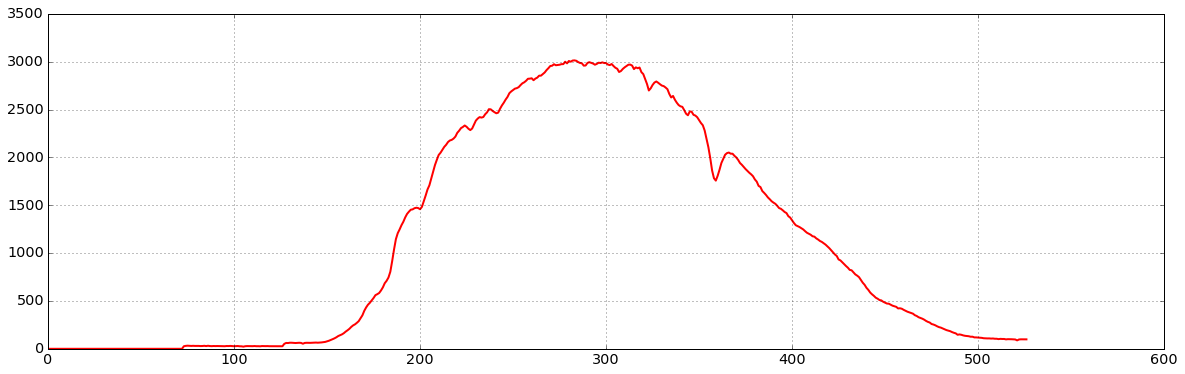

In [541]:
spec1[330:336]=spec2[330:336]  # remove bad pixel
N1=spec1.shape[0]
N2=spec2.shape[0]
N=np.min([N1,N2])
spec1_croped=spec1[0:N]
spec2_croped=spec2[0:N]
avspecsum=0.5*(spec1_croped+spec2_croped)
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(avspecsum,'r-',lw=2)
plt.ylim(0,3500)
plt.grid(True)

## search for all absorption lines
=========================================

In [542]:
ymax=3500.
ymin=0.
# O2 Frauwnoffer A 759.370
xmin_pix_o2=355
xmax_pix_o2=365
# H-alpha : Hα     656.281 nm
xmin_pix_ha=320
xmax_pix_ha=330
# H-beta : Hβ     486.134 nm
xmin_pix_hb=238
xmax_pix_hb=245
# H-gamma : Hγ     434.047 nm
xmin_pix_hg=225
xmax_pix_hg=230
# H-delta : Hδ     410.175 nm
xmin_pix_hd=198
xmax_pix_hd=204

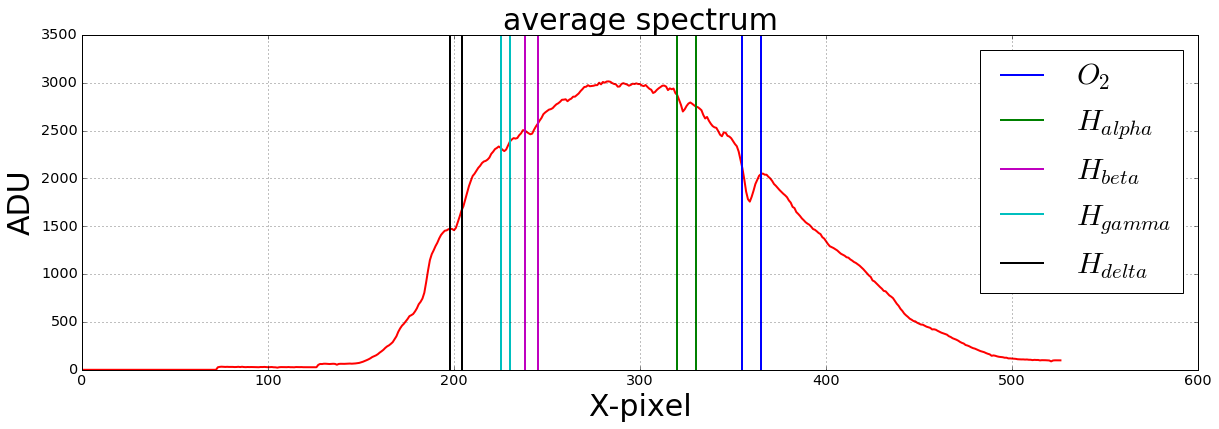

In [543]:
figfilename='Spec_Search_AbsLines.png'
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(avspecsum,'r-',lw=2) ; plt.ylim(ymin,ymax) ; plt.grid(True)
plt.plot([xmin_pix_o2,xmin_pix_o2],[ymin,ymax],'b-',label='$O_2$',lw=2)
plt.plot([xmax_pix_o2,xmax_pix_o2],[ymin,ymax],'b-',lw=2)
#H-alpha
plt.plot([xmin_pix_ha,xmin_pix_ha],[ymin,ymax],'g-',label='$H_{alpha}$',lw=2)
plt.plot([xmax_pix_ha,xmax_pix_ha],[ymin,ymax],'g-',lw=2)
#H-beta
plt.plot([xmin_pix_hb,xmin_pix_hb],[ymin,ymax],'m-',label='$H_{beta}$',lw=2)
plt.plot([xmax_pix_hb,xmax_pix_hb],[ymin,ymax],'m-',lw=2)
#H-gamma
plt.plot([xmin_pix_hg,xmin_pix_hg],[ymin,ymax],'c-',label='$H_{gamma}$',lw=2)
plt.plot([xmax_pix_hg,xmax_pix_hg],[ymin,ymax],'c-',lw=2)
#H-delta
plt.plot([xmin_pix_hd,xmin_pix_hd],[ymin,ymax],'k-',label='$H_{delta}$',lw=2)
plt.plot([xmax_pix_hd,xmax_pix_hd],[ymin,ymax],'k-',lw=2)
plt.xlabel('X-pixel',fontsize=30) ; plt.ylabel('ADU',fontsize=30) ; plt.legend(loc='best',fontsize=30) ; plt.title('average spectrum',fontsize=30)
plt.savefig(figfilename)

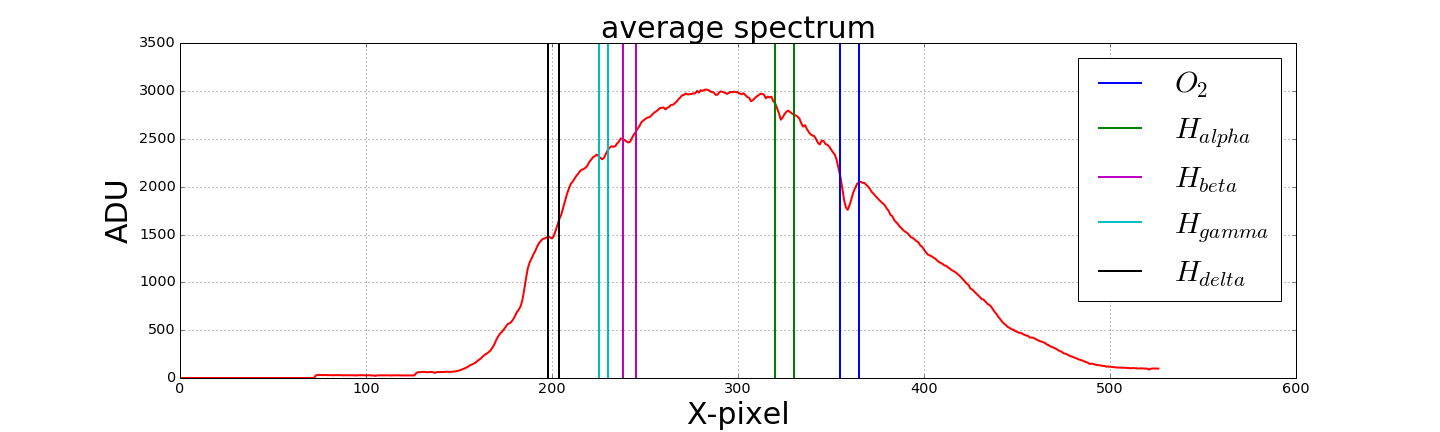

In [544]:
Image(filename=figfilename)

## Extraction of pixel position of lines
=================================================

In [545]:
peak_O2=np.min(avspecsum[xmin_pix_o2:xmax_pix_o2])
indexes_O2=np.where(avspecsum==peak_O2)
print 'index(O2)=',indexes_O2[0], 'peak(O2)=',peak_O2

index(O2)= [359] peak(O2)= 1758.11810552


In [546]:
peak_Ha=np.min(avspecsum[xmin_pix_ha:xmax_pix_ha])
indexes_Ha=np.where(avspecsum==peak_Ha)
print 'index(Halpha)=',indexes_Ha[0], 'peak(Halpha)=',peak_Ha

index(Halpha)= [323] peak(Halpha)= 2700.30947907


In [547]:
peak_Hb=np.min(avspecsum[xmin_pix_hb:xmax_pix_hb])
indexes_Hb=np.where(avspecsum==peak_Hb)
print 'index(Hbeta)=',indexes_Hb[0], 'peak(Hbeta)=',peak_Hb

index(Hbeta)= [241] peak(Hbeta)= 2462.01815739


In [548]:
peak_Hg=np.min(avspecsum[xmin_pix_hg:xmax_pix_hg])
indexes_Hg=np.where(avspecsum==peak_Hg)
print 'index(Hgamma)=',indexes_Hg[0], 'peak(Hgamma)=',peak_Hg

index(Hgamma)= [227] peak(Hgamma)= 2286.39138142


In [549]:
peak_Hd=np.min(avspecsum[xmin_pix_hd:xmax_pix_hd])
indexes_Hd=np.where(avspecsum==peak_Hd)
print 'index(Hdelta)=',indexes_Hd[0], 'peak(Hdelta)=',peak_Hd

index(Hdelta)= [200] peak(Hdelta)= 1459.00694671


## Check where are the lines 
===================================

- Where are the lines that has been found 

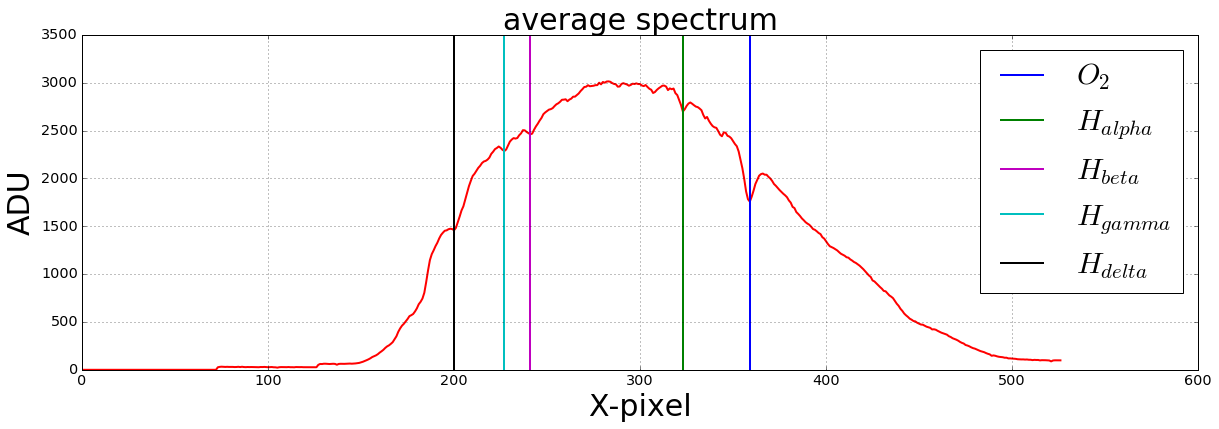

In [550]:
figfilename='Spec_Search_AbsLinesCheckPos.png'
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(avspecsum,'r-',lw=2) ; plt.ylim(ymin,ymax) ; plt.grid(True)
plt.plot([indexes_O2[0][0],indexes_O2[0][0]],[ymin,ymax],'b-',label='$O_2$',lw=2)
#H-alpha
plt.plot([indexes_Ha[0][0],indexes_Ha[0][0]],[ymin,ymax],'g-',label='$H_{alpha}$',lw=2)
#H-beta
plt.plot([indexes_Hb[0][0],indexes_Hb[0][0]],[ymin,ymax],'m-',label='$H_{beta}$',lw=2)
#H-gamma
plt.plot([indexes_Hg[0][0],indexes_Hg[0][0]],[ymin,ymax],'c-',label='$H_{gamma}$',lw=2)
#H-delta
plt.plot([indexes_Hd[0][0],indexes_Hd[0][0]],[ymin,ymax],'k-',label='$H_{delta}$',lw=2)
plt.xlabel('X-pixel',fontsize=30) ; plt.ylabel('ADU',fontsize=30) ; plt.legend(loc='best',fontsize=30) ; plt.title('average spectrum',fontsize=30)
plt.savefig(figfilename)

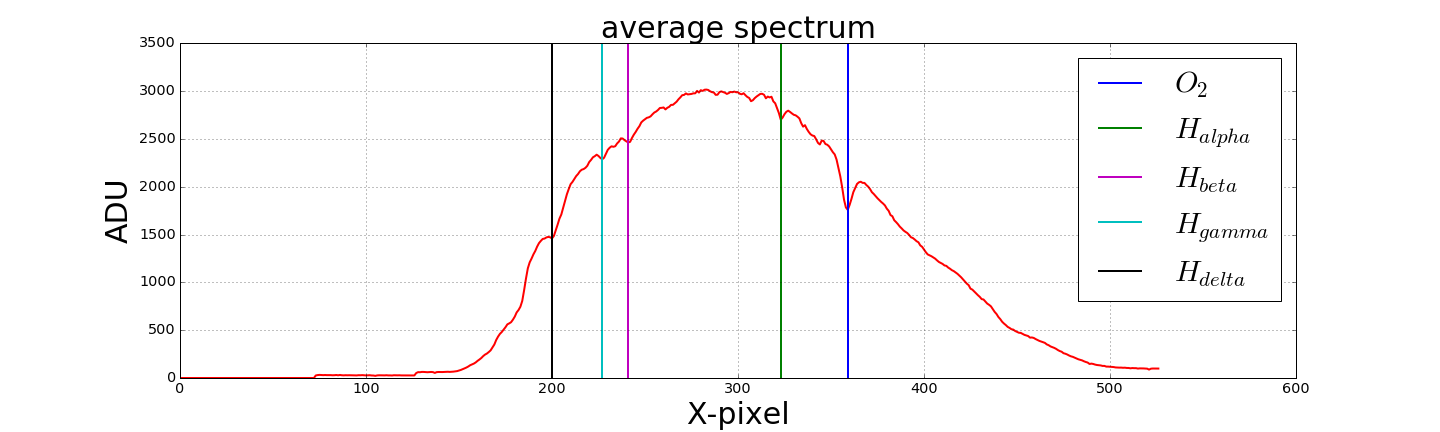

In [551]:
Image(filename=figfilename)

## Calibration curve
==========================

### Pixels points

In [552]:
pixel_axis=np.array([indexes_Hd[0], indexes_Hg[0], indexes_Hb[0],indexes_Ha[0],indexes_O2[0]])

In [553]:
pixel_axis_flat=pixel_axis.flatten()

### Wavelength points

In [554]:
wavelength_axis=np.array([410.175, 434.047,486.134, 656.281, 759.370])

### FIT pixel to wavelength and vice versa
--------

In [555]:
pixel_to_wavelength_fit_p1d=np.poly1d(np.polyfit(pixel_axis_flat,wavelength_axis,1))
wavelength_to_pixel_fit_p1d =np.poly1d( np.polyfit(wavelength_axis,pixel_axis_flat,1))

In [556]:
xfit=np.linspace(0,400,50)  # defines the pixel range

In [557]:
pfit=np.poly1d(pixel_to_wavelength_fit_p1d)
yfit=pfit(xfit)

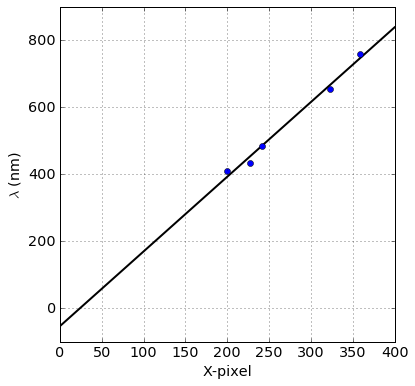

In [558]:
plt.plot(xfit,yfit,'k-',lw=2)   # plot the fitted line
plt.plot(pixel_axis,wavelength_axis,'o') # plot the points
plt.grid(True)
plt.xlabel('X-pixel')
plt.ylabel('$\lambda$ (nm)')

## Check the fit on the spectrum
==========================================

In [559]:
pix_indexes=np.arange(0,avspecsum.shape[0]) # indexes of the pixels
pix_wavelengthes=pfit(pix_indexes)          # calculate the wavelength of each pixel

In [560]:
# H-alpha : Hα     656.281 nm
# O2 Frauwnoffer A 759.370
# H-beta : Hβ     486.134 nm
# H-gamma : Hγ     434.047 nm
# H-delta : Hδ     410.175 nm
# H-epsilon : H epsilon 397,0 nm

In [561]:
# expected positions of absorption lines
ymax=3500.
ymin=0.
wl_O2line=759.37
wl_Haline=656.281 
wl_Hbline=486.134
wl_Hgline=434.047 
wl_Hdline=410.175

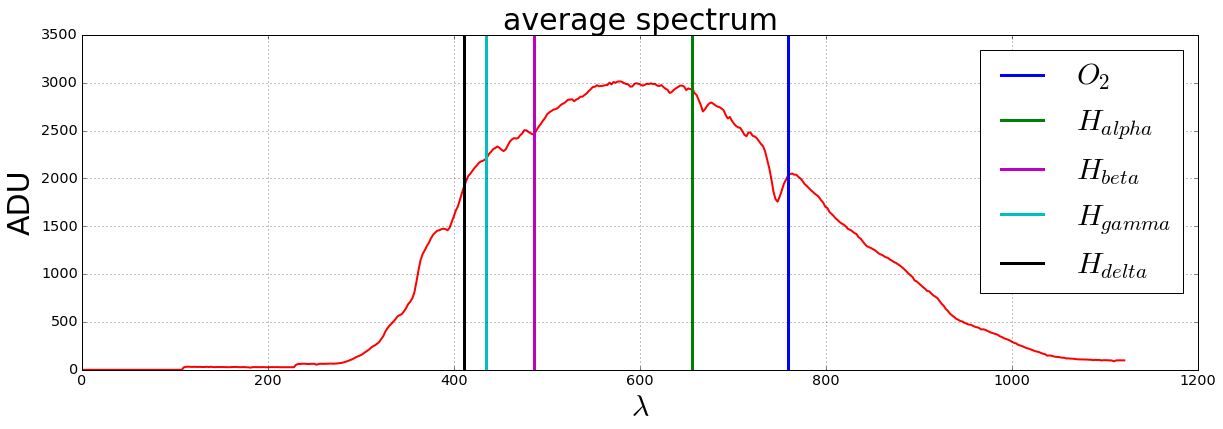

In [562]:
figfilename='Spec_Search_AbsLines_CheckFit.png'
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(pix_wavelengthes,avspecsum,'r-',lw=2)
ax.plot([wl_O2line,wl_O2line],[ymin,ymax],'b-',label='$O_2$',lw=3)
ax.plot([wl_Haline,wl_Haline],[ymin,ymax],'g-',label='$H_{alpha}$',lw=3)
ax.plot([wl_Hbline,wl_Hbline],[ymin,ymax],'m-',label='$H_{beta}$',lw=3)
ax.plot([wl_Hgline,wl_Hgline],[ymin,ymax],'c-',label='$H_{gamma}$',lw=3)
ax.plot([wl_Hdline,wl_Hdline],[ymin,ymax],'k-',label='$H_{delta}$',lw=3)
plt.ylim(0,3500)
plt.xlim(0,1200)
plt.grid(True)
plt.xlabel('$\lambda$',fontsize=30)
plt.ylabel('ADU',fontsize=30)
plt.legend(loc='best',fontsize=30)
plt.title('average spectrum',fontsize=30)
plt.savefig(figfilename)

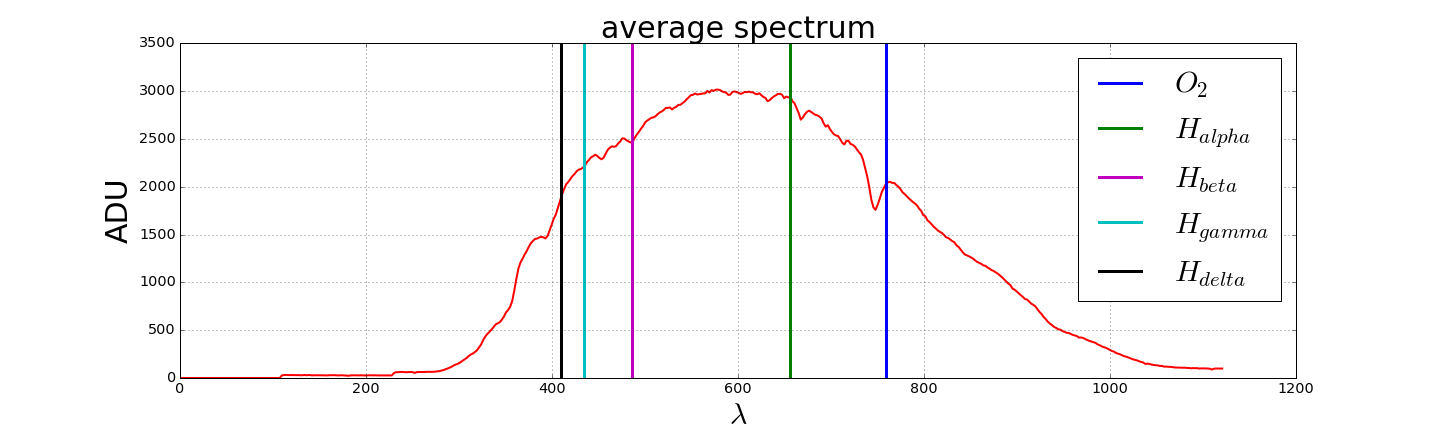

In [563]:
Image(filename=figfilename)

- The fit is not as good as expected ????

## Test parabolic fit

In [564]:
pixel_to_wavelength_fit_p2d=np.poly1d(np.polyfit(pixel_axis_flat,wavelength_axis,2))
wavelength_to_pixel_fit_p2d =np.poly1d( np.polyfit(wavelength_axis,pixel_axis_flat,2))

In [565]:
xfit2=np.linspace(0,400,50)  # defines the pixel range

In [566]:
pfit2=np.poly1d(pixel_to_wavelength_fit_p2d)
yfit2=pfit(xfit2)

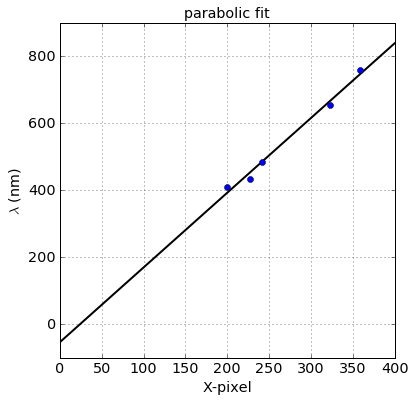

In [567]:
plt.plot(xfit2,yfit2,'k-',lw=2)   # plot the fitted line
plt.plot(pixel_axis,wavelength_axis,'o') # plot the points
plt.grid(True)
plt.xlabel('X-pixel')
plt.ylabel('$\lambda$ (nm)')
plt.title('parabolic fit')

#### There is a mis-identification of the $H_{\alpha} $,  $H_{\beta} $,... lines

## Try another guess with  $O_2$, $H_\alpha$ lines and origin

In [568]:
pixel_axis=np.array([indexes_Ha[0],indexes_O2[0]])
pixel_axis_flat=pixel_axis.flatten()

In [569]:
wavelength_axis=np.array([656.281, 759.370])

In [570]:
pixel_to_wavelength_fit_p1d=np.poly1d(np.polyfit(pixel_axis_flat,wavelength_axis,1))
wavelength_to_pixel_fit_p1d =np.poly1d( np.polyfit(wavelength_axis,pixel_axis_flat,1))

In [571]:
xfit=np.linspace(0,400,50)  # defines the pixel range

In [572]:
pfit=np.poly1d(pixel_to_wavelength_fit_p1d)
yfit=pfit(xfit)

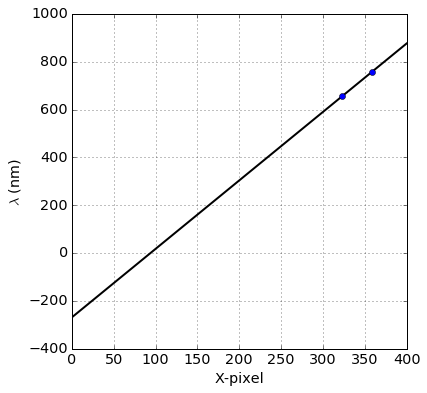

In [573]:
plt.plot(xfit,yfit,'k-',lw=2)   # plot the fitted line
plt.plot(pixel_axis,wavelength_axis,'o') # plot the points
plt.grid(True)
plt.xlabel('X-pixel')
plt.ylabel('$\lambda$ (nm)')

In [574]:
pix_indexes=np.arange(0,avspecsum.shape[0]) # indexes of the pixels
pix_wavelengthes=pfit(pix_indexes)   

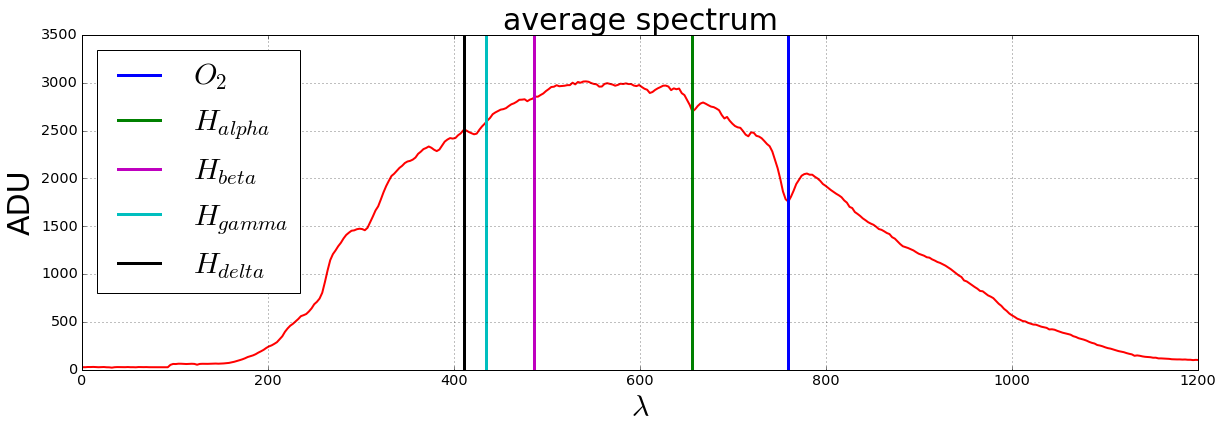

In [575]:
figfilename='Spec_Search_AbsLines_CheckFit2.png'
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(pix_wavelengthes,avspecsum,'r-',lw=2)
ax.plot([wl_O2line,wl_O2line],[ymin,ymax],'b-',label='$O_2$',lw=3)
ax.plot([wl_Haline,wl_Haline],[ymin,ymax],'g-',label='$H_{alpha}$',lw=3)
ax.plot([wl_Hbline,wl_Hbline],[ymin,ymax],'m-',label='$H_{beta}$',lw=3)
ax.plot([wl_Hgline,wl_Hgline],[ymin,ymax],'c-',label='$H_{gamma}$',lw=3)
ax.plot([wl_Hdline,wl_Hdline],[ymin,ymax],'k-',label='$H_{delta}$',lw=3)
plt.ylim(0,3500) ; plt.xlim(0,1200) ; plt.grid(True)
plt.xlabel('$\lambda$',fontsize=30) ; plt.ylabel('ADU',fontsize=30) ;plt.legend(loc='best',fontsize=30) ;
plt.title('average spectrum',fontsize=30)
plt.savefig(figfilename)

## Try another guess with  $O_2$, $H_\alpha$ lines and origin :

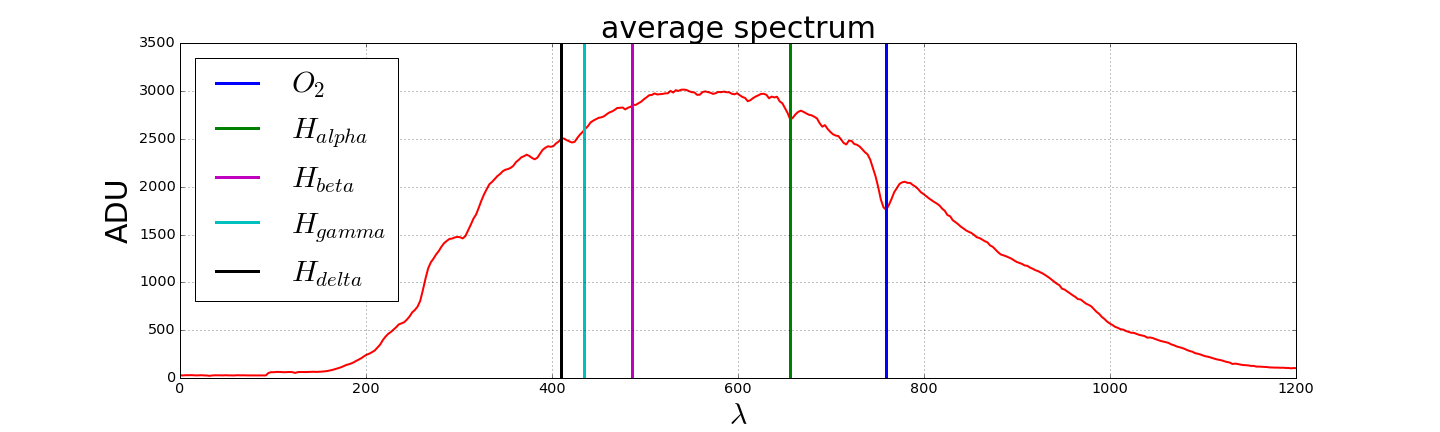

In [576]:
Image(filename=figfilename)

#### Here we forced $O_2$ and $H_\alpha$ lines fit
- this is not correct. The $H_2O$ dip is too far.


## Calibrate with $O_2$ only
=================================

In [577]:
pixel_axis=np.array([[0],indexes_O2[0]])
pixel_axis_flat=pixel_axis.flatten()

In [578]:
wavelength_axis=np.array([0, 759.370])

In [579]:
pixel_to_wavelength_fit_p1d=np.poly1d(np.polyfit(pixel_axis_flat,wavelength_axis,1))
wavelength_to_pixel_fit_p1d =np.poly1d( np.polyfit(wavelength_axis,pixel_axis_flat,1))

In [580]:
xfit=np.linspace(0,400,50)  # defines the pixel range

In [581]:
pfit=np.poly1d(pixel_to_wavelength_fit_p1d)
yfit=pfit(xfit)

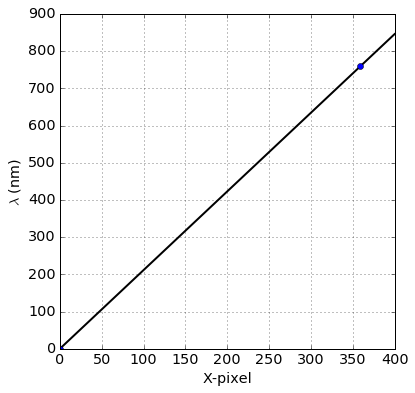

In [582]:
plt.plot(xfit,yfit,'k-',lw=2)   # plot the fitted line
plt.plot(pixel_axis,wavelength_axis,'o') # plot the points
plt.grid(True)
plt.xlabel('X-pixel')
plt.ylabel('$\lambda$ (nm)')

In [583]:
pix_indexes=np.arange(0,avspecsum.shape[0]) # indexes of the pixels
pix_wavelengthes=pfit(pix_indexes)   

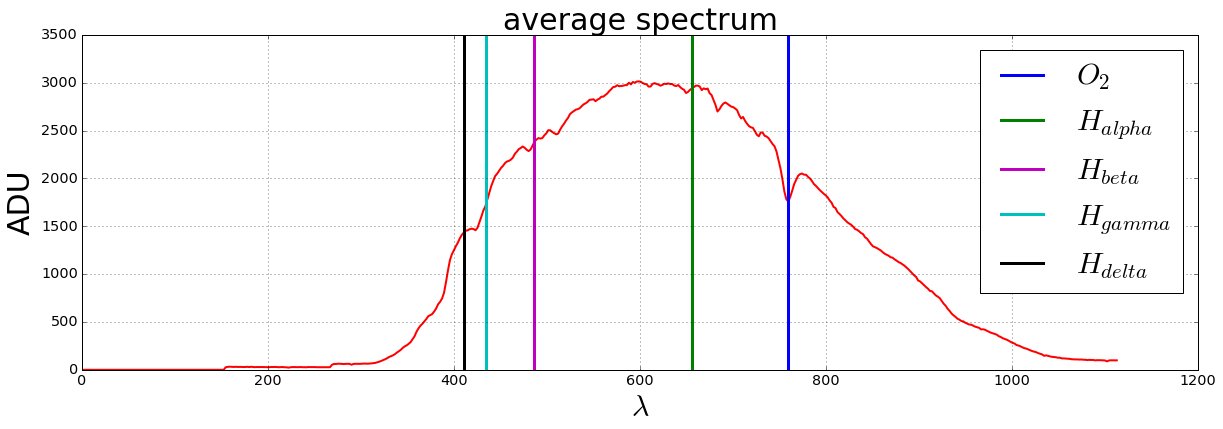

In [584]:
figfilename='Spec_Search_AbsLines_CheckFit3.png'
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(pix_wavelengthes,avspecsum,'r-',lw=2)
ax.plot([wl_O2line,wl_O2line],[ymin,ymax],'b-',label='$O_2$',lw=3)
ax.plot([wl_Haline,wl_Haline],[ymin,ymax],'g-',label='$H_{alpha}$',lw=3)
ax.plot([wl_Hbline,wl_Hbline],[ymin,ymax],'m-',label='$H_{beta}$',lw=3)
ax.plot([wl_Hgline,wl_Hgline],[ymin,ymax],'c-',label='$H_{gamma}$',lw=3)
ax.plot([wl_Hdline,wl_Hdline],[ymin,ymax],'k-',label='$H_{delta}$',lw=3)
plt.ylim(0,3500) ; plt.xlim(0,1200) ; plt.grid(True)
plt.xlabel('$\lambda$',fontsize=30) ; plt.ylabel('ADU',fontsize=30) ;plt.legend(loc='best',fontsize=30) ;
plt.title('average spectrum',fontsize=30)
plt.savefig(figfilename)

## Calibrate with $O_2$ only

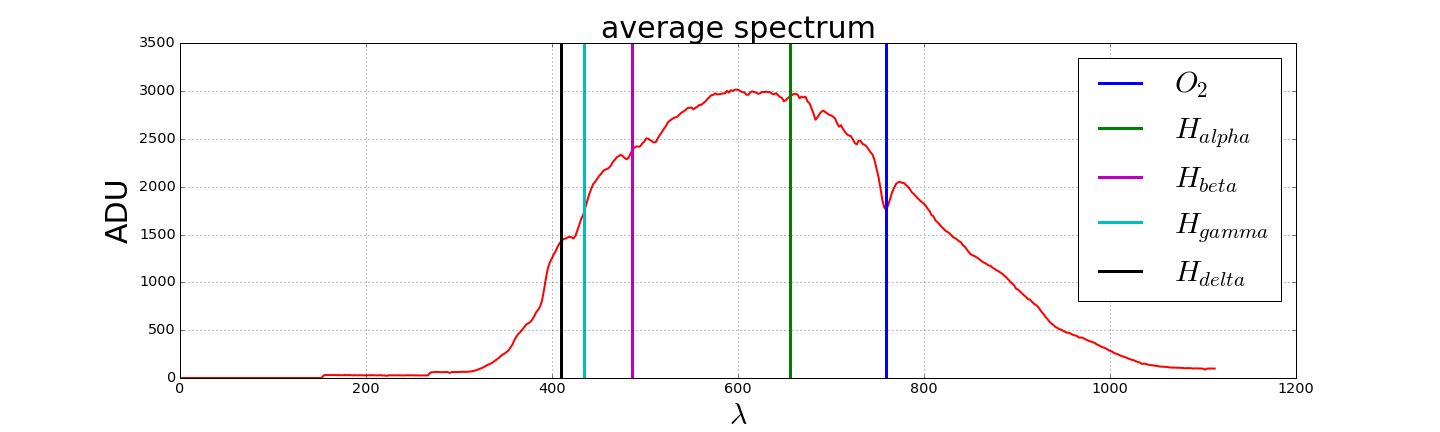

In [585]:
Image(filename=figfilename)

## Search for Fraunhaufer $O_2$ absorption lines

- A : 759,370
- B : 686,719
- a : 627.661

In [586]:
# Fraunhofer
wl_frA_O2=759.370
wl_frB_O2=686.719
wl_fra_O2=627.661

xmin_pix_frA_o2=xmin_pix_o2
xmax_pix_frA_o2=xmax_pix_o2

xmin_pix_frB_o2=xmin_pix_ha
xmax_pix_frB_o2=xmax_pix_ha-3

xmin_pix_fra_o2=304
xmax_pix_fra_o2=310

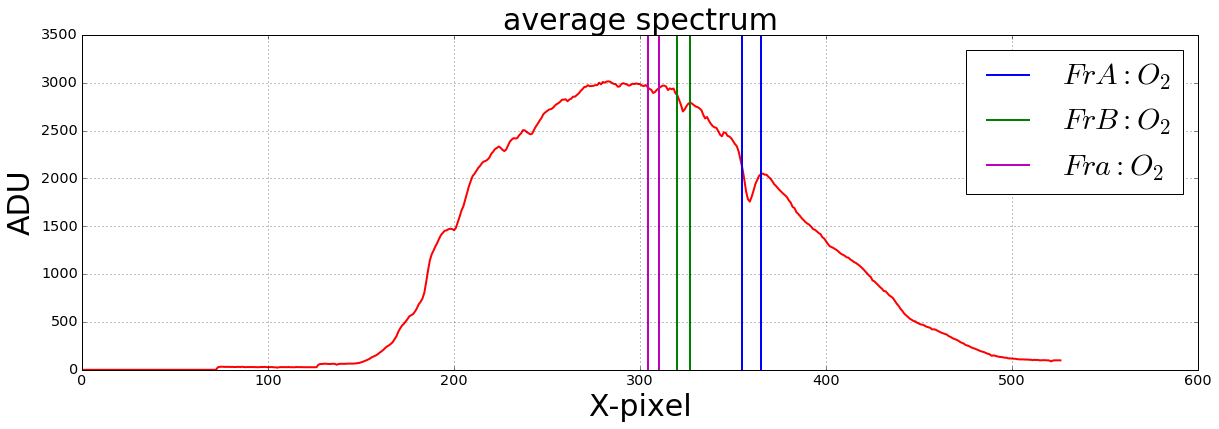

In [587]:
figfilename='Spec_Search_FraunhauferAbsLines.png'
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(avspecsum,'r-',lw=2) ; plt.ylim(ymin,ymax) ; plt.grid(True)
plt.plot([xmin_pix_frA_o2,xmin_pix_frA_o2],[ymin,ymax],'b-',label='$ Fr A : O_2$',lw=2)
plt.plot([xmax_pix_frA_o2,xmax_pix_frA_o2],[ymin,ymax],'b-',lw=2)
# FR A
plt.plot([xmin_pix_frB_o2,xmin_pix_frB_o2],[ymin,ymax],'g-',label='$Fr B : O_2 $',lw=2)
plt.plot([xmax_pix_frB_o2,xmax_pix_frB_o2],[ymin,ymax],'g-',lw=2)
#H-beta
plt.plot([xmin_pix_fra_o2,xmin_pix_fra_o2],[ymin,ymax],'m-',label='$Fr a : O_2$',lw=2)
plt.plot([xmax_pix_fra_o2,xmax_pix_fra_o2],[ymin,ymax],'m-',lw=2)

plt.xlabel('X-pixel',fontsize=30) ; plt.ylabel('ADU',fontsize=30) ; plt.legend(loc='best',fontsize=30) ; plt.title('average spectrum',fontsize=30)
plt.savefig(figfilename)

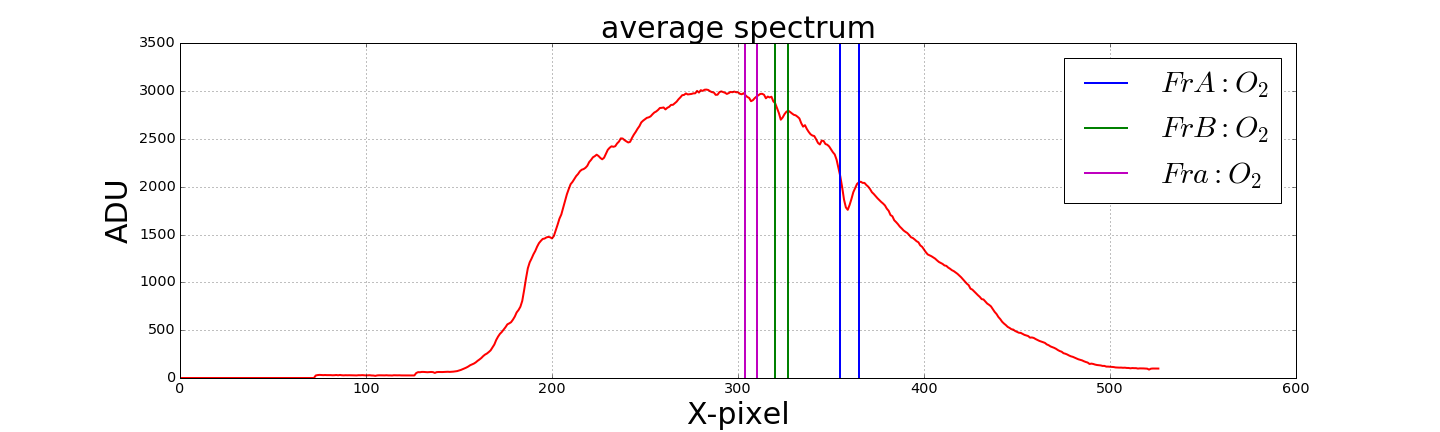

In [588]:
Image(filename=figfilename)

In [589]:
peak_FrA_O2=np.min(avspecsum[xmin_pix_frA_o2:xmax_pix_frA_o2])
indexes_FrA_O2=np.where(avspecsum==peak_FrA_O2)
print 'index(FrA-O2)=',indexes_FrA_O2[0], 'peak(FrA-O2)=',peak_FrA_O2

index(FrA-O2)= [359] peak(FrA-O2)= 1758.11810552


In [590]:
peak_FrB_O2=np.min(avspecsum[xmin_pix_frB_o2:xmax_pix_frB_o2])
indexes_FrB_O2=np.where(avspecsum==peak_FrB_O2)
print 'index(FrB-O2)=',indexes_FrB_O2[0], 'peak(FrB-O2)=',peak_FrB_O2

index(FrB-O2)= [323] peak(FrB-O2)= 2700.30947907


In [591]:
peak_Fra_O2=np.min(avspecsum[xmin_pix_fra_o2:xmax_pix_fra_o2])
indexes_Fra_O2=np.where(avspecsum==peak_Fra_O2)
print 'index(Fra-O2)=',indexes_Fra_O2[0], 'peak(Fra-O2)=',peak_Fra_O2

index(Fra-O2)= [307] peak(Fra-O2)= 2893.75934588


In [592]:
#pixel_axis=np.array([indexes_Fra_O2[0],indexes_FrB_O2[0],indexes_FrA_O2[0]])
pixel_axis=np.array([indexes_FrB_O2[0],indexes_FrA_O2[0]])
pixel_axis_flat=pixel_axis.flatten()

In [593]:
wavelength_axis=np.array([wl_frB_O2,wl_frA_O2])

In [594]:
pixel_to_wavelength_fit_p1d=np.poly1d(np.polyfit(pixel_axis_flat,wavelength_axis,1))
wavelength_to_pixel_fit_p1d =np.poly1d( np.polyfit(wavelength_axis,pixel_axis_flat,1))

In [595]:
xfit=np.linspace(0,400,50)  # defines the pixel range

In [596]:
pfit=np.poly1d(pixel_to_wavelength_fit_p1d)
yfit=pfit(xfit)

In [597]:
pfit

poly1d([  2.01808333,  34.87808333])

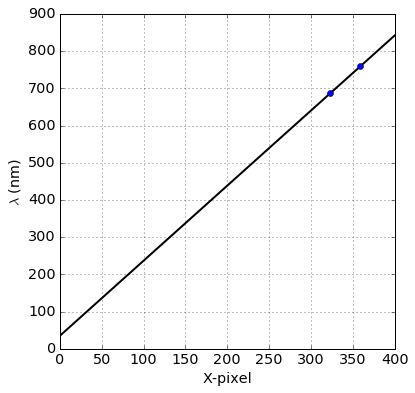

In [598]:
plt.plot(xfit,yfit,'k-',lw=2)   # plot the fitted line
plt.plot(pixel_axis,wavelength_axis,'o') # plot the points
plt.grid(True)
plt.xlabel('X-pixel')
plt.ylabel('$\lambda$ (nm)')

In [599]:
pix_indexes=np.arange(0,avspecsum.shape[0]) # indexes of the pixels
pix_wavelengthes=pfit(pix_indexes)   

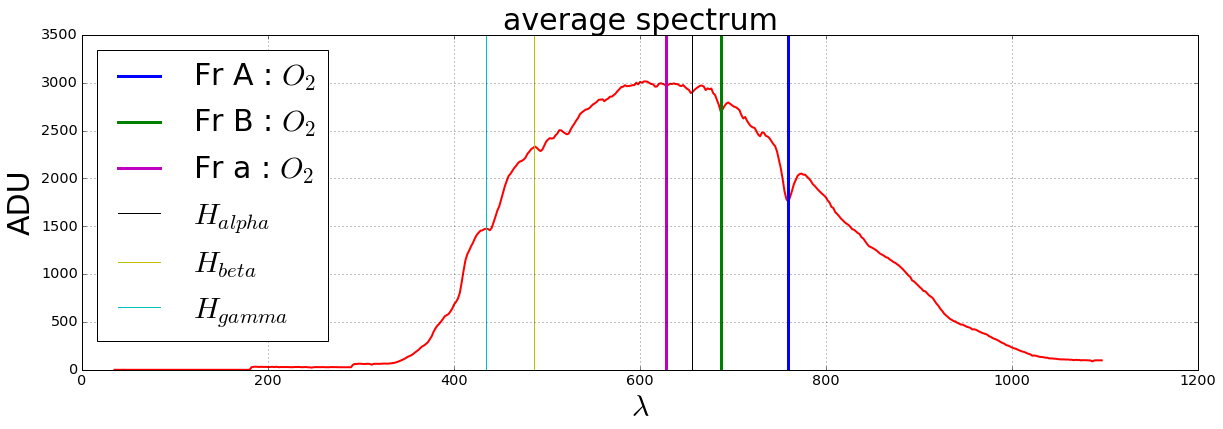

In [600]:
figfilename='Spec_Search_FRO2_AbsLines_Check.png'
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(pix_wavelengthes,avspecsum,'r-',lw=2)
ax.plot([wl_frA_O2,wl_frA_O2],[ymin,ymax],'b-',label='Fr A : $O_2$',lw=3)
ax.plot([wl_frB_O2,wl_frB_O2],[ymin,ymax],'g-',label='Fr B : $O_2$',lw=3)
ax.plot([wl_fra_O2,wl_fra_O2],[ymin,ymax],'m-',label='Fr a : $O_2$',lw=3)
ax.plot([wl_Haline,wl_Haline],[ymin,ymax],'k-',label='$H_{alpha}$',lw=1)
ax.plot([wl_Hbline,wl_Hbline],[ymin,ymax],'y-',label='$H_{beta}$',lw=1)
ax.plot([wl_Hgline,wl_Hgline],[ymin,ymax],'c-',label='$H_{gamma}$',lw=1)
plt.ylim(0,3500) ; plt.xlim(0,1200) ; plt.grid(True)
plt.xlabel('$\lambda$',fontsize=30) ; plt.ylabel('ADU',fontsize=30) ;plt.legend(loc='best',fontsize=30) ;
plt.title('average spectrum',fontsize=30)
plt.savefig(figfilename)

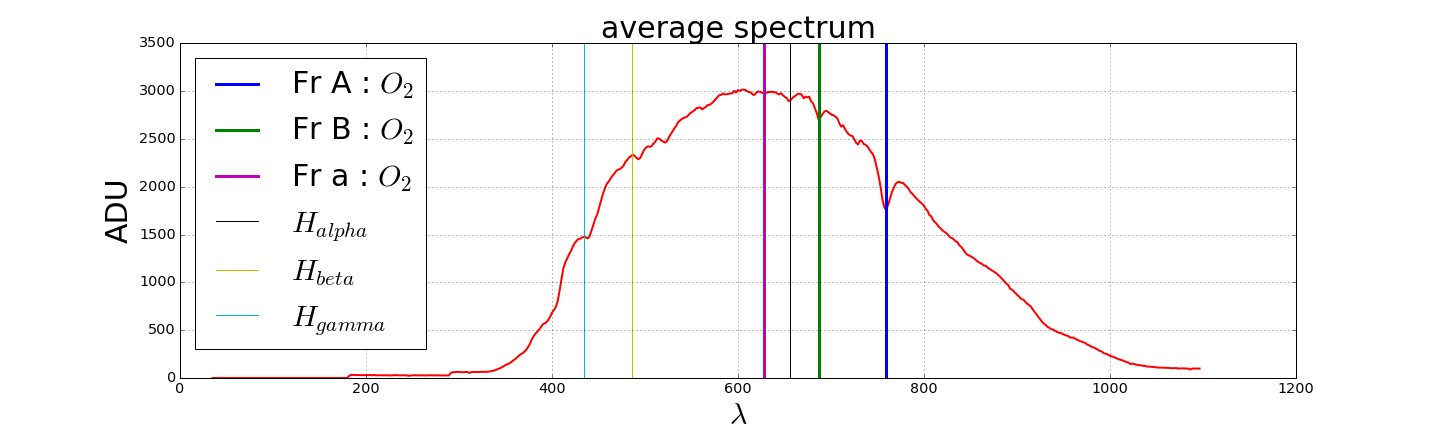

In [601]:
Image(filename=figfilename)